In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/창시구/package

/content/drive/MyDrive/창시구


In [3]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

from data_generator import Linear_Dynamics_3D
from data_processing import input_data

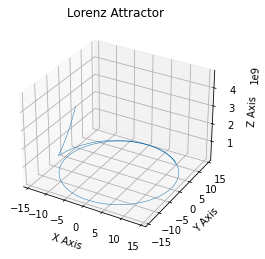

In [4]:
Dy = Linear_Dynamics_3D()
t, init, y = Dy.t, Dy.init, Dy.value
dim = y.shape[1]
Dy.describe()

In [7]:
train_size = 5000
test_size = 40
dim = np.shape(y)[1]
y = torch.tensor(sol_train).to(torch.float32)
train_set, test_set = y[:-test_size], y[-test_size:]

<ipython-input-7-08931fcdd69e>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(sol_train).to(torch.float32)


In [9]:
window_size = test_size
train_data = input_data(train_set, window_size)

In [20]:
class RNN(nn.Module):
    
  def __init__(self,input_size = dim, hidden_size = 128, num_layers = 3, out_size = dim):
    super().__init__()
    self.hidden_size = hidden_size
    self.window_size = 40
    self.num_layers = num_layers
    self.hidden = torch.zeros(num_layers,1 , hidden_size)

    self.RNN_cell = nn.RNN(input_size, hidden_size, num_layers)
    self.linear = nn.Linear(hidden_size,out_size)
    
  def forward(self,seq):
    self.out = seq.view(self.window_size,1,-1)
    # Unfolding LSTM
    RNN_out, hidden = self.RNN_cell(seq.view(self.window_size,1,-1), self.hidden)

    pred = self.linear(RNN_out.view(len(seq),-1))

    return pred

In [27]:
torch.manual_seed(42)
model = RNN()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

model

RNN(
  (RNN_cell): RNN(3, 128, num_layers=3)
  (linear): Linear(in_features=128, out_features=3, bias=True)
)

Performance on test range: 1.7133698285568e+17


<ipython-input-28-1605b31035a6>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(torch.tensor(preds[-test_size:]), y[-test_size:])


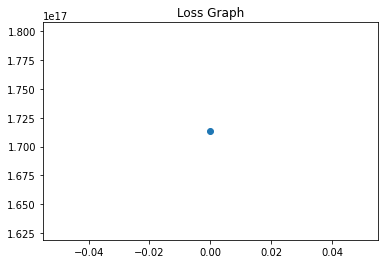

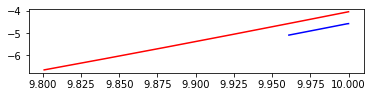

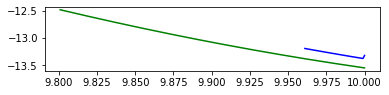

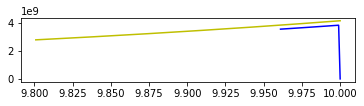

In [ ]:
epochs = 100
future = test_size
loss_list = []
for epoch in range(epochs):
    for seq, y_train in train_data:
      
      optimizer.zero_grad()
      model.hidden = torch.zeros(model.num_layers,1,model.hidden_size)
      y_pred = model(seq)
      loss = criterion(y_pred, y_train)
      loss.backward()
      optimizer.step()

            
    for f in range(future):
        seq = torch.FloatTensor(train_set[-test_size:])
        preds = train_set[-test_size:].tolist()
        with torch.no_grad():
          model.hidden = torch.zeros(model.num_layers,1,model.hidden_size)
          preds.append(model(seq)[f])

    preds = torch.tensor(preds)   
    loss = criterion(torch.tensor(preds[-test_size:]), y[-test_size:])
    loss_list.append(loss)
    print(f"Performance on test range: {loss}")
    
    if epoch % 1 == 0:
      plt.plot(loss_list,'o-')
      plt.title('Loss Graph')
      plt.show()

      plt.subplot(3, 1, 1)                
      plt.plot(t[-5*test_size:], y[-5*test_size:, 0], 'r', label='x')
      plt.plot(t[-test_size :], preds[-test_size :,0], '-b', label='predicted_x')
      plt.show()

      plt.subplot(3, 1, 2)
      plt.plot(t[-5*test_size:], y[-5*test_size:, 1], 'g', label='y')
      plt.plot(t[-test_size :], preds[-test_size :,1], '-b', label='predicted_x')
      plt.show()

      plt.subplot(3, 1, 3)
      plt.plot(t[-5*test_size:], y[-5*test_size:, 2], 'y', label='z')
      plt.plot(t[-test_size :], preds[-test_size :,2], '-b', label='predicted_x')
      plt.show()
